In [20]:
#Code to find audio file information
import soundfile as sf

# Load file
file_path = "vowel1_1.wav"
data, samplerate = sf.read(file_path)

# Basic info
num_samples = len(data)
num_channels = 1 if data.ndim == 1 else data.shape[1]
duration_sec = num_samples / samplerate

# Print results
print(f"📄 File: {file_path}")
print(f"🔢 Sample Rate     : {samplerate} Hz")
print(f"🔊 Number of Channels : {num_channels}")
print(f"🔁 Total Samples   : {num_samples}")
print(f"⏱️ Duration        : {duration_sec:.3f} seconds")


📄 File: vowel1_1.wav
🔢 Sample Rate     : 44100 Hz
🔊 Number of Channels : 1
🔁 Total Samples   : 10912
⏱️ Duration        : 0.247 seconds


In [5]:
#Code to find formants according to paper.

import numpy as np
import soundfile as sf
from numpy import hamming
from scipy.linalg import solve_toeplitz
from numpy.polynomial import Polynomial

# === Step 0: Load and Normalize the WAV File ===
filename = "vowel1_1.wav"
signal, fs = sf.read(filename)
signal = signal / np.max(np.abs(signal))

# === Step 1: Extract 30ms Frame Centered at 0.12379s ===
center_time = 0.12379
frame_len = int(0.030 * fs)
center_sample = int(center_time * fs)
start = max(0, center_sample - frame_len // 2)
frame = signal[start:start + frame_len]
windowed_frame = frame * hamming(len(frame))

# === Step 2: LPC Analysis ===
p = int(fs / 1000) + 2  # Data-driven LPC order
def compute_lpc_autocorr(x, order):
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
    R = r[:order + 1]
    r_rhs = r[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
    return np.concatenate(([1], -a))

a_lpc = compute_lpc_autocorr(windowed_frame, p)

# === Step 3: Root Extraction and Formant Screening ===
roots = np.roots(a_lpc)
roots = roots[np.imag(roots) >= 0.01]  # Real-axis rejection

def root_to_formant(root, fs):
    r = np.abs(root)
    theta = np.angle(root)
    freq = theta * fs / (2 * np.pi)
    bw = -fs / np.pi * np.log(r)
    return freq, bw

formants, bandwidths, complex_roots = [], [], []
for z in roots:
    r = np.abs(z)
    if 0.75 <= r < 1:
        f, b = root_to_formant(z, fs)
        if 90 < f < fs / 2:
            formants.append(f)
            bandwidths.append(b)
            complex_roots.append(z)

formants = np.array(formants)
bandwidths = np.array(bandwidths)
complex_roots = np.array(complex_roots)
sorted_idx = np.argsort(formants)
formants = formants[sorted_idx]
bandwidths = bandwidths[sorted_idx]
complex_roots = complex_roots[sorted_idx]

print("✅ Total valid formants:", len(formants))
for i, (f, b) in enumerate(zip(formants, bandwidths)):
    print(f"F{i+1} = {f:.2f} Hz\tB{i+1} = {b:.2f} Hz")

# === Step 4: Merger Detection Based on Angle Criterion ===
merger_pairs = []
for i in range(len(complex_roots)):
    for j in range(i+1, len(complex_roots)):
        z1, z2 = complex_roots[i], complex_roots[j]
        r = (np.abs(z1) + np.abs(z2)) / 2
        theta1, theta2 = np.angle(z1), np.angle(z2)
        try:
            threshold = 2 * np.arccos(2 * r / (1 + r**2))
            if abs(theta1 - theta2) < threshold:
                merger_pairs.append((i, j))
        except:
            continue

print("\n🔍 Suspicious merger pairs (angle check):", merger_pairs)

# === Step 5: Cauchy Integral Pole Confirmation ===
def cauchy_integral_count(a_coeffs, theta1, theta2):
    N = 300
    r_cauchy = 0.875
    ts = np.linspace(theta1, theta2, N)
    z = r_cauchy * np.exp(1j * ts)
    A = np.polyval(a_coeffs[::-1], z)
    Aprime = np.polyval(np.polyder(a_coeffs[::-1]), z)
    integrand = Aprime / A
    dz = np.gradient(z)
    integral = np.sum(integrand * dz)
    return int(np.round(np.real(integral / (2j * np.pi))))

confirmed_mergers = []
for i, j in merger_pairs:
    z1, z2 = complex_roots[i], complex_roots[j]
    theta1, theta2 = np.angle(z1), np.angle(z2)
    count = cauchy_integral_count(a_lpc, min(theta1, theta2), max(theta1, theta2))
    print(f"  → Cauchy check for pair F{i+1}-F{j+1}: {count} poles")
    if count == 2:
        confirmed_mergers.append((i, j))

print("\n✅ Confirmed mergers:", confirmed_mergers)

# === Step 6: Polynomial Decomposition with Correction ===
def poly_decomp_separate(a_coeffs, z1, z2):
    p = len(a_coeffs) - 1
    fz = Polynomial(a_coeffs[::-1]).convert().coef
    fz = np.concatenate([fz, np.zeros(p)])

    r1 = np.abs(z1)
    theta1 = np.angle(z1)
    z1_mean = r1 * np.exp(1j * theta1)
    z2_mean = np.conj(z1_mean)
    s = - (z1_mean + z2_mean).real
    t = (r1 ** 2)

    b = np.zeros(p - 1)
    b[0] = 1
    for k in range(1, p - 1):
        b[k] = fz[k] - s * b[k - 1] - t * (b[k - 2] if k > 1 else 0)

    alpha = fz[p - 1] - s * b[-1] - t * b[-2]
    beta = fz[p] - t * b[-1]

    c = np.zeros(p - 2)
    c[0] = 1
    for k in range(1, p - 2):
        c[k] = b[k] - s * c[k - 1] - t * (c[k - 2] if k > 1 else 0)

    R11 = b[-1] - s * c[-1] - t * c[-2]
    R21 = -t * c[-1]
    R12 = b[-2] - s * c[-2] - t * c[-3]
    R22 = b[-1] - t * c[-2]

    A = np.array([[R11, R12], [R21, R22]])
    rhs = np.array([alpha, beta])
    u, v = np.linalg.solve(A, rhs)

    s1 = s + u
    t1 = t + v
    new_roots = np.roots([1, s1, t1])
    return new_roots

# === Step 7: Reconstruct Separated Roots ===
separated_roots = []
used_indices = set()
for i, j in confirmed_mergers:
    z1, z2 = complex_roots[i], complex_roots[j]
    new_roots = poly_decomp_separate(a_lpc, z1, z2)
    print(f"\n🧩 Decomposed roots for F{i+1}, F{j+1}:", new_roots)
    separated_roots.extend(new_roots)
    used_indices.update([i, j])

# Include all unused original roots
for i, z in enumerate(complex_roots):
    if i not in used_indices:
        separated_roots.append(z)

# === Step 8: Final Formant and Bandwidth Estimation ===
formants_final, bandwidths_final = [], []
for z in separated_roots:
    r, theta = np.abs(z), np.angle(z)
    if 0.75 <= r < 1:
        f = (theta * fs) / (2 * np.pi)
        b = -(fs / np.pi) * np.log(r)
        if 90 < f < fs / 2:
            formants_final.append(f)
            bandwidths_final.append(b)

formants_final = np.array(formants_final)
bandwidths_final = np.array(bandwidths_final)
idx = np.argsort(formants_final)
formants_final = formants_final[idx][:5]
bandwidths_final = bandwidths_final[idx][:5]

# === Step 9: Display Results ===
print("\n🎯 Final PDLPC Estimated Formants and Bandwidths:")
for i in range(len(formants_final)):
    print(f"F{i+1} = {formants_final[i]:.2f} Hz\tB{i+1} = {bandwidths_final[i]:.2f} Hz")


✅ Total valid formants: 22
F1 = 511.71 Hz	B1 = 195.62 Hz
F2 = 921.91 Hz	B2 = 106.88 Hz
F3 = 2597.66 Hz	B3 = 105.77 Hz
F4 = 3376.37 Hz	B4 = 143.36 Hz
F5 = 3719.28 Hz	B5 = 388.90 Hz
F6 = 5071.14 Hz	B6 = 810.17 Hz
F7 = 6321.38 Hz	B7 = 706.88 Hz
F8 = 7347.75 Hz	B8 = 790.93 Hz
F9 = 8309.04 Hz	B9 = 1613.44 Hz
F10 = 9046.88 Hz	B10 = 539.13 Hz
F11 = 10316.02 Hz	B11 = 459.51 Hz
F12 = 11220.58 Hz	B12 = 649.73 Hz
F13 = 12283.39 Hz	B13 = 371.81 Hz
F14 = 13469.34 Hz	B14 = 544.21 Hz
F15 = 14413.48 Hz	B15 = 763.83 Hz
F16 = 15433.88 Hz	B16 = 691.71 Hz
F17 = 16453.57 Hz	B17 = 987.66 Hz
F18 = 17185.48 Hz	B18 = 955.20 Hz
F19 = 18489.79 Hz	B19 = 946.73 Hz
F20 = 19386.98 Hz	B20 = 2232.01 Hz
F21 = 19648.68 Hz	B21 = 640.27 Hz
F22 = 20903.83 Hz	B22 = 827.01 Hz

🔍 Suspicious merger pairs (angle check): [(7, 8), (8, 9), (16, 17), (18, 19), (19, 20)]
  → Cauchy check for pair F8-F9: 0 poles
  → Cauchy check for pair F9-F10: 0 poles
  → Cauchy check for pair F17-F18: 0 poles
  → Cauchy check for pair F19-F20: 0 p

In [35]:
import numpy as np
import pandas as pd
import soundfile as sf
from numpy import hamming
from scipy.linalg import solve_toeplitz
from numpy.polynomial import Polynomial
import os

# === Function to compute LPC coefficients using autocorrelation method ===
def compute_lpc_autocorr(x, order):
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
    R = r[:order + 1]
    r_rhs = r[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
    return np.concatenate(([1], -a))

# === Convert root to formant frequency and bandwidth ===
def root_to_formant(root, fs):
    r = np.abs(root)
    theta = np.angle(root)
    freq = theta * fs / (2 * np.pi)
    bw = -fs / np.pi * np.log(r)
    return freq, bw

# === Cauchy integral pole count ===
def cauchy_integral_count(a_coeffs, theta1, theta2, fs):
    N = 300
    r_cauchy = 0.875
    ts = np.linspace(theta1, theta2, N)
    z = r_cauchy * np.exp(1j * ts)
    A = np.polyval(a_coeffs[::-1], z)
    Aprime = np.polyval(np.polyder(a_coeffs[::-1]), z)
    integrand = Aprime / A
    dz = np.gradient(z)
    integral = np.sum(integrand * dz)
    return int(np.round(np.real(integral / (2j * np.pi))))

# === Polynomial decomposition to separate merged roots ===
def poly_decomp_separate(a_coeffs, z1, z2):
    p = len(a_coeffs) - 1
    fz = Polynomial(a_coeffs[::-1]).convert().coef
    fz = np.concatenate([fz, np.zeros(p)])

    r1 = np.abs(z1)
    theta1 = np.angle(z1)
    z1_mean = r1 * np.exp(1j * theta1)
    z2_mean = np.conj(z1_mean)
    s = - (z1_mean + z2_mean).real
    t = r1 ** 2

    b = np.zeros(p - 1)
    b[0] = 1
    for k in range(1, p - 1):
        b[k] = fz[k] - s * b[k - 1] - t * (b[k - 2] if k > 1 else 0)

    alpha = fz[p - 1] - s * b[-1] - t * b[-2]
    beta = fz[p] - t * b[-1]

    c = np.zeros(p - 2)
    c[0] = 1
    for k in range(1, p - 2):
        c[k] = b[k] - s * c[k - 1] - t * (c[k - 2] if k > 1 else 0)

    R11 = b[-1] - s * c[-1] - t * c[-2]
    R21 = -t * c[-1]
    R12 = b[-2] - s * c[-2] - t * c[-3]
    R22 = b[-1] - t * c[-2]

    A = np.array([[R11, R12], [R21, R22]])
    rhs = np.array([alpha, beta])
    u, v = np.linalg.solve(A, rhs)

    s1 = s + u
    t1 = t + v
    new_roots = np.roots([1, s1, t1])
    return new_roots

# === Process single file ===
def process_pdlpc_autocorr(filepath):
    try:
        signal, fs = sf.read(filepath)
        signal = signal / np.max(np.abs(signal))

        # Step 1: 30 ms window at 0.12379s
        center_time = 0.12379
        frame_len = int(0.060 * fs)
        center_sample = int(center_time * fs)
        start = max(0, center_sample - frame_len // 2)
        frame = signal[start:start + frame_len]
        windowed = frame * hamming(len(frame))

        # Step 2: LPC (autocorrelation method)
        p = int(fs / 1000) + 2
        a_lpc = compute_lpc_autocorr(windowed, p)

        # Step 3: Initial formant extraction
        roots = np.roots(a_lpc)
        roots = roots[np.imag(roots) >= 0.01]
        formants, bandwidths, complex_roots = [], [], []
        for z in roots:
            r = np.abs(z)
            if 0.75 <= r < 1:
                f, b = root_to_formant(z, fs)
                if 90 < f < fs / 2:
                    formants.append(f)
                    bandwidths.append(b)
                    complex_roots.append(z)

        formants = np.array(formants)
        bandwidths = np.array(bandwidths)
        complex_roots = np.array(complex_roots)
        idx = np.argsort(formants)
        formants = formants[idx]
        bandwidths = bandwidths[idx]
        complex_roots = complex_roots[idx]

        # Step 4: Merger detection
        merger_pairs = []
        for i in range(len(complex_roots)):
            for j in range(i+1, len(complex_roots)):
                z1, z2 = complex_roots[i], complex_roots[j]
                r = (np.abs(z1) + np.abs(z2)) / 2
                theta1, theta2 = np.angle(z1), np.angle(z2)
                try:
                    threshold = 2 * np.arccos(2 * r / (1 + r**2))
                    if abs(theta1 - theta2) < threshold:
                        merger_pairs.append((i, j))
                except:
                    continue

        # Step 5: Cauchy check
        confirmed_mergers = []
        for i, j in merger_pairs:
            z1, z2 = complex_roots[i], complex_roots[j]
            theta1, theta2 = np.angle(z1), np.angle(z2)
            count = cauchy_integral_count(a_lpc, min(theta1, theta2), max(theta1, theta2), fs)
            if count == 2:
                confirmed_mergers.append((i, j))

        # Step 6: Polynomial decomposition
        separated_roots = []
        used = set()
        for i, j in confirmed_mergers:
            new_roots = poly_decomp_separate(a_lpc, complex_roots[i], complex_roots[j])
            separated_roots.extend(new_roots)
            used.update([i, j])
        for i, z in enumerate(complex_roots):
            if i not in used:
                separated_roots.append(z)

        # Step 7: Final formants
        final_formants, final_bandwidths = [], []
        for z in separated_roots:
            r, theta = np.abs(z), np.angle(z)
            if 0.75 <= r < 1:
                f = (theta * fs) / (2 * np.pi)
                b = -(fs / np.pi) * np.log(r)
                if 90 < f < fs / 2:
                    final_formants.append(f)
                    final_bandwidths.append(b)

        final_formants = np.array(final_formants)
        final_bandwidths = np.array(final_bandwidths)
        idx = np.argsort(final_formants)
        final_formants = final_formants[idx][:5]
        final_bandwidths = final_bandwidths[idx][:5]

        # Pad with NaN if fewer than 5
        while len(final_formants) < 5:
            final_formants = np.append(final_formants, np.nan)
            final_bandwidths = np.append(final_bandwidths, np.nan)

        return final_formants.tolist() + final_bandwidths.tolist()

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return [np.nan] * 10

# === Batch loop ===
results = []
for i in range(1, 41):
    fname = f"vowel1_{i}.wav" #----------------------------------------------------------------------------Change Here
    if os.path.exists(fname):
        values = process_pdlpc_autocorr(fname)
        results.append([fname] + values)
    else:
        print(f"File not found: {fname}")
        results.append([fname] + [np.nan]*10)

# === Save to CSV ===
columns = ["filename", "F1", "F2", "F3", "F4", "F5", "B1", "B2", "B3", "B4", "B5"]
df = pd.DataFrame(results, columns=columns)
df.to_csv("vowel1_formants_bandwidths_new.csv", index=False) #------------------------------------------------Change Here
print("✅ Saved to vowel1_formants_bandwidths_new.csv")


✅ Saved to vowel1_formants_bandwidths_new.csv


✅ Hankel matrix shape: (1323, 1324)
✅ SVD complete


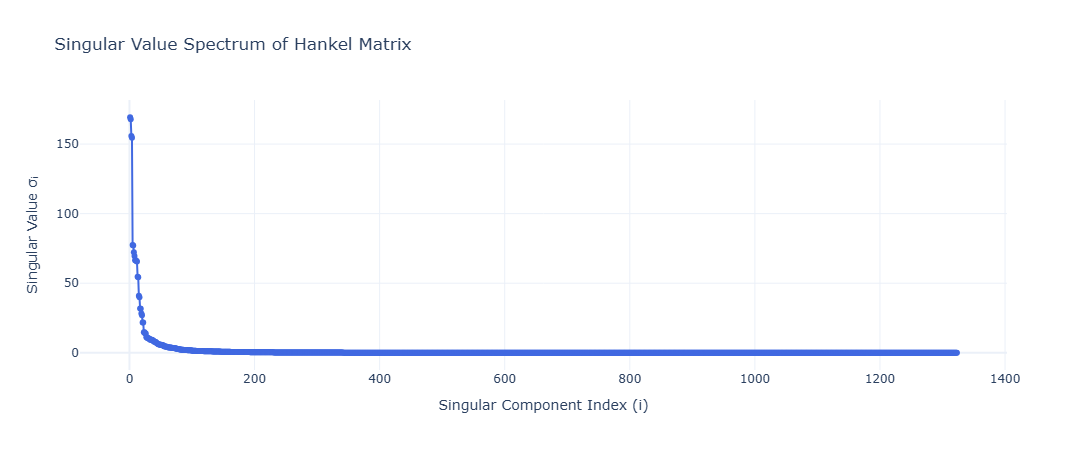

In [4]:
#Singular value code and plot.

import numpy as np
import soundfile as sf
import plotly.graph_objs as go
from scipy.linalg import svd

# === Step 1: Load and normalize signal ===
file_path = "vowel1_2.wav"
signal, fs = sf.read(file_path)
signal = signal / np.max(np.abs(signal))  # Normalize to [-1, 1]

# === Step 2: Extract 60 ms segment centered at 0.12379s ===
center_time = 0.12379  # in seconds
frame_len = int(0.060 * fs)  # 60 ms frame
center_sample = int(center_time * fs)
start = center_sample - frame_len // 2
end = center_sample + frame_len // 2
segment = signal[start:end]

# === Step 3: Construct Hankel matrix with L = N/2 ===
N = len(segment)
L = N // 2
K = N - L + 1
hankel_matrix = np.column_stack([segment[i:i+L] for i in range(K)])

print(f"✅ Hankel matrix shape: {hankel_matrix.shape}")

# === Step 4: Apply SVD ===
U, S, VT = svd(hankel_matrix, full_matrices=False)
print("✅ SVD complete")

# === Step 5: Plot singular value spectrum using Plotly ===
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(1, len(S)+1),
    y=S,
    mode='lines+markers',
    name='Singular Values',
    marker=dict(size=6),
    line=dict(color='royalblue')
))
fig.update_layout(
    title="Singular Value Spectrum of Hankel Matrix",
    xaxis_title="Singular Component Index (i)",
    yaxis_title="Singular Value σᵢ",
    template="plotly_white",
    width=800,
    height=450
)
fig.show()


In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Assumed already available ===
# fs = 44100
# formants_final = np.array([...])
# bandwidths_final = np.array([...])
# hankel_matrix = ...
# U, S, VT = np.linalg.svd(hankel_matrix, full_matrices=False)

L = hankel_matrix.shape[0]
K = hankel_matrix.shape[1]
max_components = len(S)

formant_band_pairs = list(zip(formants_final, bandwidths_final))
formant_contributions = {f"F{i+1}": [] for i in range(len(formant_band_pairs))}

# === Anti-diagonal averaging helper ===
def average_anti_diagonals(matrix):
    rows, cols = matrix.shape
    N = rows + cols - 1
    result = np.zeros(N)
    count = np.zeros(N)
    for i in range(rows):
        for j in range(cols):
            result[i + j] += matrix[i, j]
            count[i + j] += 1
    return result / count

# === Main loop: keep increasing number of components until all formants have ≥2 peaks
step_size = 10
used_components = 0

print("🔁 Searching for first 2 valid SVD components per formant...\n")

for i in tqdm(range(max_components), desc="Analyzing SVD Components"):
    Hi = S[i] * np.outer(U[:, i], VT[i, :])
    signal_i = average_anti_diagonals(Hi)
    signal_i *= np.hamming(len(signal_i))
    spectrum = np.abs(np.fft.rfft(signal_i))
    freqs = np.fft.rfftfreq(len(signal_i), d=1/fs)

    peak_idx = np.argmax(spectrum)
    peak_freq = freqs[peak_idx]
    peak_mag = spectrum[peak_idx]

    for j, (f, bw) in enumerate(formant_band_pairs):
        label = f"F{j+1}"
        lower = f - bw / 2
        upper = f + bw / 2
        if lower <= peak_freq <= upper:
            if len(formant_contributions[label]) < 2:
                formant_contributions[label].append((i + 1, peak_freq, peak_mag))

    used_components = i + 1

    # Check: all formants have at least 2 contributors?
    if all(len(contribs) >= 2 for contribs in formant_contributions.values()):
        break

# === Weighted peak frequency summary using only first 2 contributors
rows = []
for label, contributors in formant_contributions.items():
    if contributors:
        selected = contributors[:2]
        total_weight = sum(mag for _, _, mag in selected)
        weighted_freq = sum(freq * mag for _, freq, mag in selected) / total_weight
        formant_index = int(label[1:]) - 1
        formant_freq, bandwidth = formant_band_pairs[formant_index]
        component_indices = [i for i, _, _ in selected]

        rows.append({
            "Formant": label,
            "Formant Freq (Hz)": round(formant_freq, 2),
            "Bandwidth (Hz)": round(bandwidth, 2),
            "Weighted SVD Peak Freq (Hz)": round(weighted_freq, 2),
            "Num Contributing SVD Components": len(selected),
            "Contributing Component Indexes": str(component_indices)
        })
    else:
        print(f"⚠️ Formant {label} has no matching SVD peaks.")

# === Output ===
df_formant_svd = pd.DataFrame(rows)
print(f"\n✅ Used {used_components} SVD components to obtain at least 2 contributors per formant.\n")
print(df_formant_svd)


🔁 Searching for first 2 valid SVD components per formant...



Analyzing SVD Components:   2%|▏         | 23/1323 [00:27<25:32,  1.18s/it]


✅ Used 24 SVD components to obtain at least 2 contributors per formant.

  Formant  Formant Freq (Hz)  Bandwidth (Hz)  Weighted SVD Peak Freq (Hz)  \
0      F1             539.10          144.54                       516.67   
1      F2             908.28          289.84                       783.33   
2      F3            2156.53         2093.43                      2333.33   
3      F4            2323.01           30.81                      2333.33   
4      F5            3613.79           56.07                      3633.33   

   Num Contributing SVD Components Contributing Component Indexes  
0                                2                         [1, 2]  
1                                2                         [5, 6]  
2                                2                        [9, 10]  
3                                2                        [9, 10]  
4                                2                       [23, 24]  


In [36]:
import numpy as np
import pandas as pd
import soundfile as sf
import os
from scipy.linalg import svd
from tqdm import tqdm

# === Load Formant Table ===
df_formants = pd.read_csv("vowel1_formants_bandwidths_new.csv")
df_formants.set_index("filename", inplace=True)

# === Anti-diagonal averaging ===
def average_anti_diagonals(matrix):
    rows, cols = matrix.shape
    result = np.zeros(rows + cols - 1)
    count = np.zeros_like(result)
    for i in range(rows):
        for j in range(cols):
            result[i + j] += matrix[i, j]
            count[i + j] += 1
    return result / count

# === Begin Processing ===
all_rows = []

print("🔁 Starting adaptive SVD formant contribution analysis...\n")

for speaker_id in tqdm(range(1, 41), desc="🎙️ Processing", ncols=80):
    fname = f"vowel1_{speaker_id}.wav"
    if not os.path.exists(fname):
        print(f"❌ File not found: {fname}")
        continue

    try:
        audio, fs = sf.read(fname)
        audio = audio / np.max(np.abs(audio))

        # Get formants and bandwidths
        row_formants = df_formants.loc[fname]
        F_vals = row_formants[[f"F{i}" for i in range(1, 6)]].values
        B_vals = row_formants[[f"B{i}" for i in range(1, 6)]].values
        if np.any(np.isnan(F_vals)) or np.any(np.isnan(B_vals)):
            continue
        formant_band_pairs = list(zip(F_vals, B_vals))

        # Segment
        center_time = 0.12379
        frame_len = int(0.060 * fs)
        center_sample = int(center_time * fs)
        segment = audio[center_sample - frame_len // 2: center_sample + frame_len // 2]

        # Hankel matrix and SVD
        N = len(segment)
        L = N // 2
        K = N - L + 1
        H = np.column_stack([segment[i:i+L] for i in range(K)])
        U, S, VT = svd(H, full_matrices=False)
        max_components = len(S)

        # Adaptive loop until 2 matches per formant
        formant_contributions = {f"F{i+1}": [] for i in range(5)}
        step = 10
        used_components = 0

        for i in range(0, max_components):
            Hi = S[i] * np.outer(U[:, i], VT[i, :])
            signal_i = average_anti_diagonals(Hi)
            signal_i *= np.hamming(len(signal_i))

            spectrum = np.abs(np.fft.rfft(signal_i))
            freqs = np.fft.rfftfreq(len(signal_i), d=1/fs)

            peak_idx = np.argmax(spectrum)
            peak_freq = freqs[peak_idx]
            peak_mag = spectrum[peak_idx]

            for j, (f, bw) in enumerate(formant_band_pairs):
                label = f"F{j+1}"
                if len(formant_contributions[label]) < 2:
                    if f - bw/2 <= peak_freq <= f + bw/2:
                        formant_contributions[label].append((i + 1, peak_freq, peak_mag))

            used_components += 1

            if all(len(c) >= 2 for c in formant_contributions.values()):
                break

        # Prepare output row
        row = {"filename": fname}
        for i in range(5):
            f = F_vals[i]
            b = B_vals[i]
            label = f"F{i+1}"
            matches = formant_contributions[label]

            if matches:
                total_weight = sum(mag for _, _, mag in matches)
                weighted_freq = sum(freq * mag for _, freq, mag in matches) / total_weight
                row[f"F{i+1}"] = round(f, 2)
                row[f"B{i+1}"] = round(b, 2)
                row[f"Weighted_Peak_F{i+1}"] = round(weighted_freq, 2)
                row[f"Num_Contributors_F{i+1}"] = len(matches)
                row[f"Component_Indexes_F{i+1}"] = str([c[0] for c in matches])
            else:
                row[f"F{i+1}"] = round(f, 2)
                row[f"B{i+1}"] = round(b, 2)
                row[f"Weighted_Peak_F{i+1}"] = np.nan
                row[f"Num_Contributors_F{i+1}"] = 0
                row[f"Component_Indexes_F{i+1}"] = "[]"

        row["Total_Components_Used"] = used_components
        all_rows.append(row)

    except Exception as e:
        print(f"❌ Error in {fname}: {e}")
        continue

# === Save Output ===
df_out = pd.DataFrame(all_rows)
df_out.to_csv("vowel1_formant_svd_contributions_adaptive.csv", index=False)
print("\n✅ Saved: vowel1_formant_svd_contributions_adaptive.csv")


🔁 Starting adaptive SVD formant contribution analysis...



🎙️ Processing: 100%|█████████████████████████| 40/40 [2:57:57<00:00, 266.93s/it]


✅ Saved: vowel1_formant_svd_contributions_adaptive.csv


In [36]:
# === Fair comparison of models predicting Weighted SVD Peaks ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# ---------------- Config ----------------
CSV = "vowel1_formant_svd_contributions_adaptive.csv"
TEST_SIZE = 0.25
SEED = 42
USE_RIDGE = False     # flip to True if you want a tiny bit of regularization
ALPHA = 1.0
# ---------------------------------------

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Load and clean
df = pd.read_csv(CSV).dropna(subset=[f"Weighted_Peak_F{i}" for i in range(1,6)]).reset_index(drop=True)

print(f"Rows after cleaning: {len(df)}")

# ===== (A) Multi-output model: predict [WP1..WP5] from all [F1..F5, B1..B5] =====
X_all = df[[f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)]].values
Y_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values

Xtr, Xte, Ytr, Yte = train_test_split(X_all, Y_all, test_size=TEST_SIZE, random_state=SEED)

Model = Ridge(alpha=ALPHA) if USE_RIDGE else LinearRegression()
mo = Model.fit(Xtr, Ytr)
Yhat = mo.predict(Xte)

print("\n=== (A) Multi-output: X = [F1..F5,B1..B5]  →  Y = [WP1..WP5]  (TEST set) ===")
for i in range(5):
    r2 = r2_score(Yte[:, i], Yhat[:, i])
    e  = rmse(Yte[:, i], Yhat[:, i])
    print(f"WP{i+1}: RMSE={e:.2f} Hz, R²={r2:.4f}")

# ===== (B) Per-formant models with the SAME protocol: predict WPi from (Fi, Bi) =====
print("\n=== (B) Per-formant: X = (Fi,Bi)  →  Y = WPi  (TEST set, same split protocol) ===")
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    Xtr, Xte, ytr, yte = train_test_split(Xi, yi, test_size=TEST_SIZE, random_state=SEED)
    m = Model.fit(Xtr, ytr)
    yhat = m.predict(Xte)
    r2 = r2_score(yte, yhat)
    e  = rmse(yte, yhat)
    print(f"WP{i}: RMSE={e:.2f} Hz, R²={r2:.4f}")

# ===== (C) (Optional) Per-formant IN-SAMPLE (to show optimism when not splitting) =====
print("\n=== (C) Per-formant: X = (Fi,Bi)  →  Y = WPi  (IN-SAMPLE, NO split) ===")
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    m = Model.fit(Xi, yi)
    yhat = m.predict(Xi)
    r2 = r2_score(yi, yhat)
    e  = rmse(yi, yhat)
    print(f"WP{i}: RMSE={e:.2f} Hz, R²={r2:.4f}  <-- optimistic (same data used to train & test)")


Rows after cleaning: 39

=== (A) Multi-output: X = [F1..F5,B1..B5]  →  Y = [WP1..WP5]  (TEST set) ===
WP1: RMSE=30.83 Hz, R²=0.9090
WP2: RMSE=348.56 Hz, R²=-3.7763
WP3: RMSE=399.26 Hz, R²=0.5733
WP4: RMSE=83.80 Hz, R²=0.9473
WP5: RMSE=284.19 Hz, R²=0.7314

=== (B) Per-formant: X = (Fi,Bi)  →  Y = WPi  (TEST set, same split protocol) ===
WP1: RMSE=22.13 Hz, R²=0.9531
WP2: RMSE=174.15 Hz, R²=-0.1923
WP3: RMSE=206.74 Hz, R²=0.8856
WP4: RMSE=117.32 Hz, R²=0.8967
WP5: RMSE=159.31 Hz, R²=0.9156

=== (C) Per-formant: X = (Fi,Bi)  →  Y = WPi  (IN-SAMPLE, NO split) ===
WP1: RMSE=42.01 Hz, R²=0.8973  <-- optimistic (same data used to train & test)
WP2: RMSE=75.83 Hz, R²=0.7776  <-- optimistic (same data used to train & test)
WP3: RMSE=161.27 Hz, R²=0.9180  <-- optimistic (same data used to train & test)
WP4: RMSE=257.52 Hz, R²=0.7539  <-- optimistic (same data used to train & test)
WP5: RMSE=123.41 Hz, R²=0.9114  <-- optimistic (same data used to train & test)


Here’s what these numbers say in the context of your project:

1. Why the numbers differ
(A) Multi-output (all formants as features)

WP1, WP4, WP5 look good (R² > 0.73, WP4 > 0.94).

WP3 is moderate (0.57).

WP2 is very bad (negative R²) → the model does worse than just predicting the mean.

This means using all [F1..F5, B1..B5] as features didn’t help WP2 — in fact it hurt because unrelated formant features add noise.

(B) Per-formant with same test split

WP1, WP3, WP4, WP5 all improve noticeably compared to (A).

WP2 improves (R² −3.77 → −0.19) but is still poor → likely a data or matching noise problem for F2, not just model choice.

This tells us predicting WPi from just (Fi, Bi) is cleaner and more stable for most formants.

(C) Per-formant in-sample (no split)

All R² values are higher than in (B) because you’re evaluating on the same data you trained on — this is optimistic and not a fair measure of generalization.

The big drop from (C) → (B) is exactly the overfitting gap.

2. Key insights
F2 is the problem child

In all cases, WP2’s R² is much lower than the others (even negative on test data).

That means the relationship between PD-LPC (F2, B2) and the chosen SVD peaks for F2 is unstable.

Could be due to:

F1 and F2 being close in frequency → bandwidth overlap → mismatched peaks.

Peak selection inside ±B/2 occasionally grabbing a harmonic or noise.

Only two contributors being too few if one is off-band.

Per-formant models generalize better

Removing cross-formant features reduces noise and improves performance for WP1, WP3, WP5.

WP4 actually drops slightly in R² from (A) → (B), but the difference is small.

In-sample results are misleading

Example: WP4 in-sample R² = 0.75 but test R² = 0.90 → the model actually generalizes better than it looks in-sample because of noise in the training fit.

Conversely, WP2 in-sample R² = 0.78 but test R² = −0.19 → big drop means overfitting to quirks in the training data.

3. Action plan from this
Investigate F2 matching:

Visual check of SVD peaks vs F2 band for outlier files.

Try stricter matching criteria (bandwidth lower bound or ±0.4·B instead of ±0.5·B).

Try allowing >2 contributors if second peak is weak.

Test power-weighted peaks instead of mag-weighted.

For the formant correction model part of your thesis:

Report both multi-output and per-formant test results, noting that per-formant features are more stable and interpretable.

Explicitly flag F2 as a challenging case and explain why (overlap, possible nasalisation influence, etc.).



In [38]:
# === Minimal per-formant + inverse correction models ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# ----------------
CSV = "vowel1_formant_svd_contributions_adaptive.csv"
TEST_SIZE = 0.25
SEED = 42
# ----------------

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# === Load & clean ===
df = pd.read_csv(CSV)
need = [f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)] + [f"Weighted_Peak_F{i}" for i in range(1,6)]
df = df.dropna(subset=need).reset_index(drop=True)
print(f"Rows after cleaning: {len(df)}\n")

# =========================================================
# (A) Per-formant forward models: WP_i ~ F_i, B_i
# =========================================================
print("=== (A) Per-formant forward models: WP_i ~ F_i, B_i (TEST set) ===")
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    Xtr, Xte, ytr, yte = train_test_split(Xi, yi, test_size=TEST_SIZE, random_state=SEED)

    model = LinearRegression().fit(Xtr, ytr)
    yhat = model.predict(Xte)
    e, r2 = rmse(yte, yhat), r2_score(yte, yhat)
    a, b = model.coef_.tolist()
    c = model.intercept_

    print(f"WP{i}: RMSE={e:.2f} Hz, R²={r2:.4f}  |  ŷ = {a:.4f}·F{i} + {b:.4f}·B{i} + {c:.4f}")

# =========================================================
# (B) Inverse correction models: F_i ~ WP_i
# =========================================================
print("\n=== (B) Inverse correction models: F_i ~ WP_i (TEST set) ===")
for i in range(1,6):
    Xi = df[[f"Weighted_Peak_F{i}"]].values
    yi = df[f"F{i}"].values
    Xtr, Xte, ytr, yte = train_test_split(Xi, yi, test_size=TEST_SIZE, random_state=SEED)

    inv_model = LinearRegression().fit(Xtr, ytr)
    yhat = inv_model.predict(Xte)
    e, r2 = rmse(yte, yhat), r2_score(yte, yhat)
    a = inv_model.coef_[0]
    b = inv_model.intercept_

    print(f"F{i}: RMSE={e:.2f} Hz, R²={r2:.4f}  |  ŷ = {a:.4f}·WP{i} + {b:.4f}")


Rows after cleaning: 39

=== (A) Per-formant forward models: WP_i ~ F_i, B_i (TEST set) ===
WP1: RMSE=22.13 Hz, R²=0.9531  |  ŷ = 1.0585·F1 + 0.1035·B1 + -31.0855
WP2: RMSE=174.15 Hz, R²=-0.1923  |  ŷ = 0.9801·F2 + -0.3301·B2 + 65.8405
WP3: RMSE=206.74 Hz, R²=0.8856  |  ŷ = 1.1981·F3 + 0.1083·B3 + -511.7644
WP4: RMSE=117.32 Hz, R²=0.8967  |  ŷ = 1.1232·F4 + -0.1905·B4 + -269.5996
WP5: RMSE=159.31 Hz, R²=0.9156  |  ŷ = 1.0436·F5 + -0.3294·B5 + -105.6886

=== (B) Inverse correction models: F_i ~ WP_i (TEST set) ===
F1: RMSE=23.96 Hz, R²=0.9338  |  ŷ = 0.8681·WP1 + 47.0304
F2: RMSE=98.05 Hz, R²=-0.3267  |  ŷ = 0.7435·WP2 + 252.8320
F3: RMSE=131.61 Hz, R²=0.9159  |  ŷ = 0.7848·WP3 + 497.6285
F4: RMSE=182.58 Hz, R²=0.7212  |  ŷ = 0.5772·WP4 + 1308.6738
F5: RMSE=228.73 Hz, R²=0.4682  |  ŷ = 0.8180·WP5 + 763.6014


In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

def rmse(y_true, y_pred): 
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Load & clean
df = pd.read_csv("vowel1_formant_svd_contributions_adaptive.csv")
need = [f"Weighted_Peak_F{i}" for i in range(1,6)] + [f"F{i}" for i in range(1,6)]
df = df.dropna(subset=need).reset_index(drop=True)

# Common split indices for EVERY model so results are comparable
idx = np.arange(len(df))
train_idx, test_idx = train_test_split(idx, test_size=0.25, random_state=42)

# ========= A) Multi-output: F = f(WP1..WP5) =========
X_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values
Y_all = df[[f"F{i}" for i in range(1,6)]].values

XtrA, XteA = X_all[train_idx], X_all[test_idx]
YtrA, YteA = Y_all[train_idx], Y_all[test_idx]

mo = LinearRegression().fit(XtrA, YtrA)
YhatA = mo.predict(XteA)

print("=== (A) Multi-output: F ~ [WP1..WP5]  (same split) ===")
for i in range(5):
    print(f"F{i+1}: RMSE={rmse(YteA[:,i], YhatA[:,i]):.2f} Hz, R²={r2_score(YteA[:,i], YhatA[:,i]):.4f}")
print()

# ========= B) Per-formant: Fi = g(WPi) (single predictor) =========
print("=== (B) Per-formant: Fi ~ WPi  (same split) ===")
for i in range(1,6):
    Xi = df[[f"Weighted_Peak_F{i}"]].values
    yi = df[f"F{i}"].values
    XtrB, XteB = Xi[train_idx], Xi[test_idx]
    ytrB, yteB = yi[train_idx], yi[test_idx]

    m = LinearRegression().fit(XtrB, ytrB)
    yhatB = m.predict(XteB)
    a = float(m.coef_[0]); b = float(m.intercept_)
    print(f"F{i}: RMSE={rmse(yteB, yhatB):.2f} Hz, R²={r2_score(yteB, yhatB):.4f}  |  ŷ = {a:.4f}·WP{i} + {b:.4f}")


=== (A) Multi-output: F ~ [WP1..WP5]  (same split) ===
F1: RMSE=61.06 Hz, R²=0.5696
F2: RMSE=94.19 Hz, R²=-0.2243
F3: RMSE=109.64 Hz, R²=0.9416
F4: RMSE=157.42 Hz, R²=0.7927
F5: RMSE=183.64 Hz, R²=0.6572

=== (B) Per-formant: Fi ~ WPi  (same split) ===
F1: RMSE=23.96 Hz, R²=0.9338  |  ŷ = 0.8681·WP1 + 47.0304
F2: RMSE=98.05 Hz, R²=-0.3267  |  ŷ = 0.7435·WP2 + 252.8320
F3: RMSE=131.61 Hz, R²=0.9159  |  ŷ = 0.7848·WP3 + 497.6285
F4: RMSE=182.58 Hz, R²=0.7212  |  ŷ = 0.5772·WP4 + 1308.6738
F5: RMSE=228.73 Hz, R²=0.4682  |  ŷ = 0.8180·WP5 + 763.6014


1️⃣ F1 behaves very well with the per-formant model
Multi-output: R² = 0.57 (moderate fit)

Per-formant: R² = 0.93, RMSE drops from ~61 Hz → ~24 Hz

Interpretation: WP1 is a very strong predictor for F1 by itself. Including other WPs in the multi-output model actually introduces noise, likely because higher-formant WPs are not relevant to F1 and add collinearity.

2️⃣ F2 is the problem child
Multi-output: R² = –0.22 (worse than guessing the mean)

Per-formant: R² = –0.33 (still worse)

Interpretation: WP2 is poorly aligned with true F2. This is not a regression problem — it’s an upstream extraction issue:

WP2 may be contaminated by F1/F3 harmonics or by SVD component mismatch.

Bandwidth-based matching may be too wide or narrow, missing true F2 peaks.

F2 for /ɔ/ can shift dramatically depending on speaker and may fall close to F1 or F3, making it harder for the adaptive SVD selection to lock onto it.

3️⃣ F3 is strong in both, slightly better in multi-output
Multi-output: R² = 0.94 (excellent)

Per-formant: R² = 0.92 (still excellent)

Interpretation: WP3 is highly correlated with F3, but having other WPs helps just a bit — likely because some F3 energy leaks into higher or lower components, and the multi-output model can use them.

4️⃣ F4 & F5 need cross-formant information
Multi-output: F4 = 0.79, F5 = 0.66

Per-formant: F4 = 0.72, F5 = 0.47

Interpretation: WP4 and WP5 alone don’t capture the full story. High formants have lower SNR and more spectral overlap, so the regression benefits from borrowing signal from other WPs.

📌 Big-picture takeaways
F1 & F3: Can be modeled very accurately with simple one-variable equations (per-formant).

F4 & F5: Multi-output modeling is better because of noise and overlap in higher formants.

F2: Needs algorithmic improvement in WP2 extraction — until WP2 tracks true F2 more closely, no regression will rescue it.

Model choice:

If you want interpretable, clean equations: use per-formant for F1, F3.

If you want best predictive performance: use multi-output for F4, F5.

F2 requires rework in the SVD selection stage before any modeling.

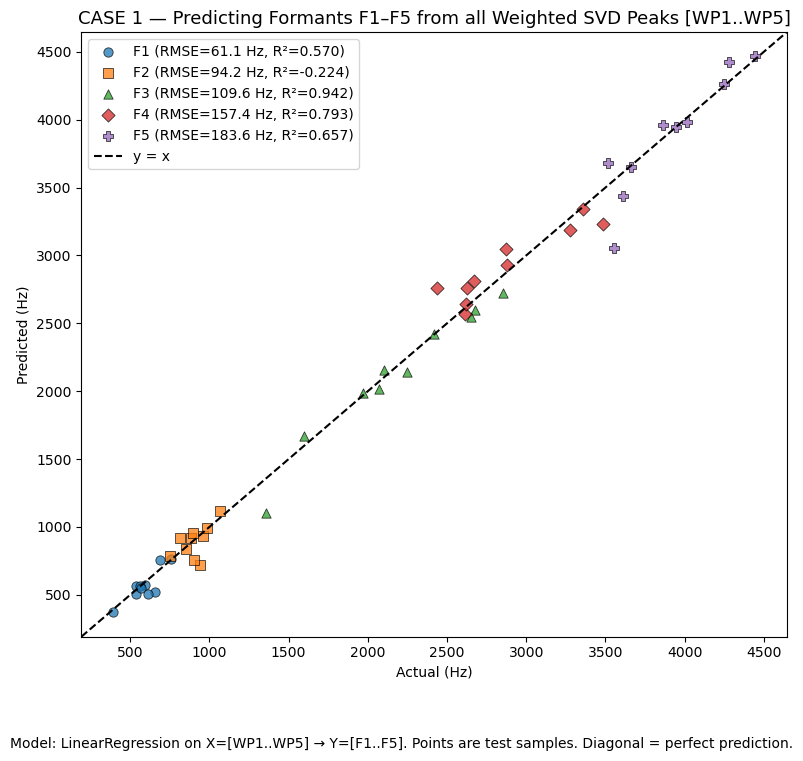

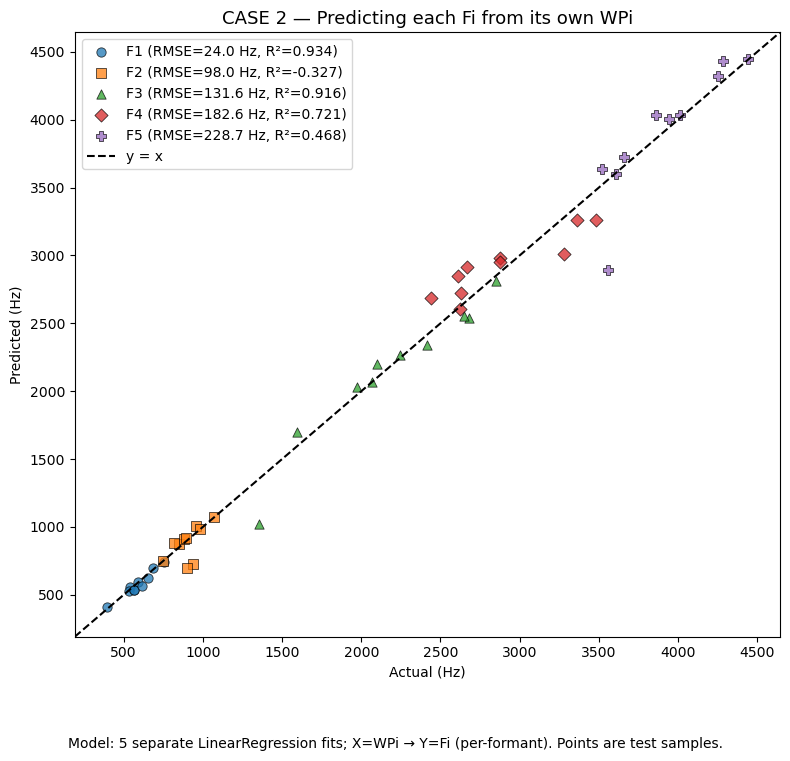

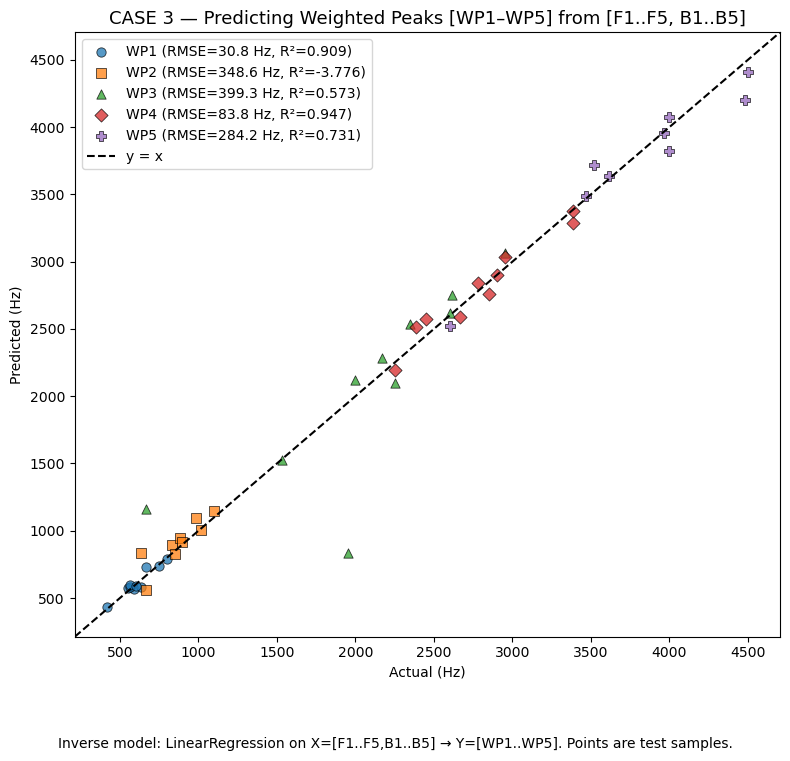

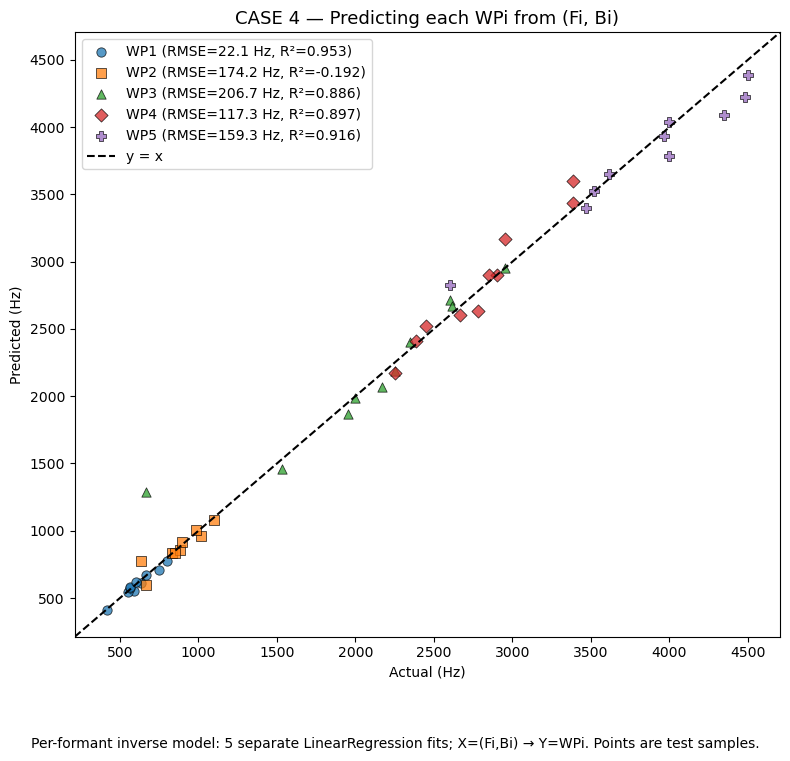

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# === Load & clean ===
df = pd.read_csv("vowel1_formant_svd_contributions_adaptive.csv")
need = [f"Weighted_Peak_F{i}" for i in range(1,6)] + [f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)]
df = df.dropna(subset=need).reset_index(drop=True)

# === Common train/test split indices for fairness across all cases ===
rng_idx = np.arange(len(df))
train_idx, test_idx = train_test_split(rng_idx, test_size=0.25, random_state=42)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# === Styling ===
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"]
markers = ["o","s","^","D","P"]
formants = [f"F{i}" for i in range(1,6)]

def plot_one_figure(all_pairs, title, caption, xlab="Actual (Hz)", ylab="Predicted (Hz)"):
    """
    all_pairs: list of dicts, each with keys:
      - name (e.g., F1)
      - x (actual), y (predicted) arrays
      - color, marker
      - rmse, r2 (floats)
    """
    plt.figure(figsize=(8,7))
    # Determine global range for diagonal
    all_true = np.concatenate([p["x"] for p in all_pairs])
    lo, hi = np.min(all_true), np.max(all_true)
    pad = 0.05 * (hi - lo + 1e-9)
    lo -= pad; hi += pad

    # Scatter per formant
    for p in all_pairs:
        lbl = f'{p["name"]} (RMSE={p["rmse"]:.1f} Hz, R²={p["r2"]:.3f})'
        plt.scatter(p["x"], p["y"], s=45, alpha=0.75,
                    edgecolors="k", linewidths=0.6,
                    c=p["color"], marker=p["marker"], label=lbl)

    # Diagonal
    plt.plot([lo, hi], [lo, hi], "k--", lw=1.5, label="y = x")

    plt.title(title, fontsize=13)
    plt.xlabel(xlab); plt.ylabel(ylab)
    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.legend(loc="best", frameon=True)
    # Caption
    plt.figtext(0.5, -0.06, caption, ha="center", va="top", fontsize=10)
    plt.tight_layout()
    plt.show()

# =========================
# CASE 1: Multi-output  F ~ [WP1..WP5]
# =========================
X_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values
Y_all = df[[f"F{i}" for i in range(1,6)]].values
mo_model = LinearRegression().fit(X_all[train_idx], Y_all[train_idx])
Yhat = mo_model.predict(X_all[test_idx])

pairs = []
for i, f in enumerate(formants):
    y_true = Y_all[test_idx, i]
    y_pred = Yhat[:, i]
    pairs.append({
        "name": f,
        "x": y_true, "y": y_pred,
        "color": colors[i], "marker": markers[i],
        "rmse": rmse(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 1 — Predicting Formants F1–F5 from all Weighted SVD Peaks [WP1..WP5]",
    caption="Model: LinearRegression on X=[WP1..WP5] → Y=[F1..F5]. Points are test samples. Diagonal = perfect prediction."
)

# =========================
# CASE 2: Per-formant  Fi ~ WPi
# =========================
pairs = []
for i in range(1,6):
    Xi = df[[f"Weighted_Peak_F{i}"]].values
    yi = df[f"F{i}"].values
    m = LinearRegression().fit(Xi[train_idx], yi[train_idx])
    y_pred = m.predict(Xi[test_idx])
    pairs.append({
        "name": f"F{i}",
        "x": yi[test_idx], "y": y_pred,
        "color": colors[i-1], "marker": markers[i-1],
        "rmse": rmse(yi[test_idx], y_pred),
        "r2": r2_score(yi[test_idx], y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 2 — Predicting each Fi from its own WPi",
    caption="Model: 5 separate LinearRegression fits; X=WPi → Y=Fi (per-formant). Points are test samples."
)

# =========================
# CASE 3: Multi-output inverse  WP ~ [F1..F5, B1..B5]
# =========================
X_all = df[[f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)]].values
Y_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values
mo_model = LinearRegression().fit(X_all[train_idx], Y_all[train_idx])
Yhat = mo_model.predict(X_all[test_idx])

pairs = []
for i in range(5):
    y_true = Y_all[test_idx, i]
    y_pred = Yhat[:, i]
    pairs.append({
        "name": f"WP{i+1}",
        "x": y_true, "y": y_pred,
        "color": colors[i], "marker": markers[i],
        "rmse": rmse(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 3 — Predicting Weighted Peaks [WP1–WP5] from [F1..F5, B1..B5]",
    caption="Inverse model: LinearRegression on X=[F1..F5,B1..B5] → Y=[WP1..WP5]. Points are test samples."
)

# =========================
# CASE 4: Per-formant inverse  WPi ~ (Fi, Bi)
# =========================
pairs = []
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    m = LinearRegression().fit(Xi[train_idx], yi[train_idx])
    y_pred = m.predict(Xi[test_idx])
    pairs.append({
        "name": f"WP{i}",
        "x": yi[test_idx], "y": y_pred,
        "color": colors[i-1], "marker": markers[i-1],
        "rmse": rmse(yi[test_idx], y_pred),
        "r2": r2_score(yi[test_idx], y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 4 — Predicting each WPi from (Fi, Bi)",
    caption="Per-formant inverse model: 5 separate LinearRegression fits; X=(Fi,Bi) → Y=WPi. Points are test samples."
)


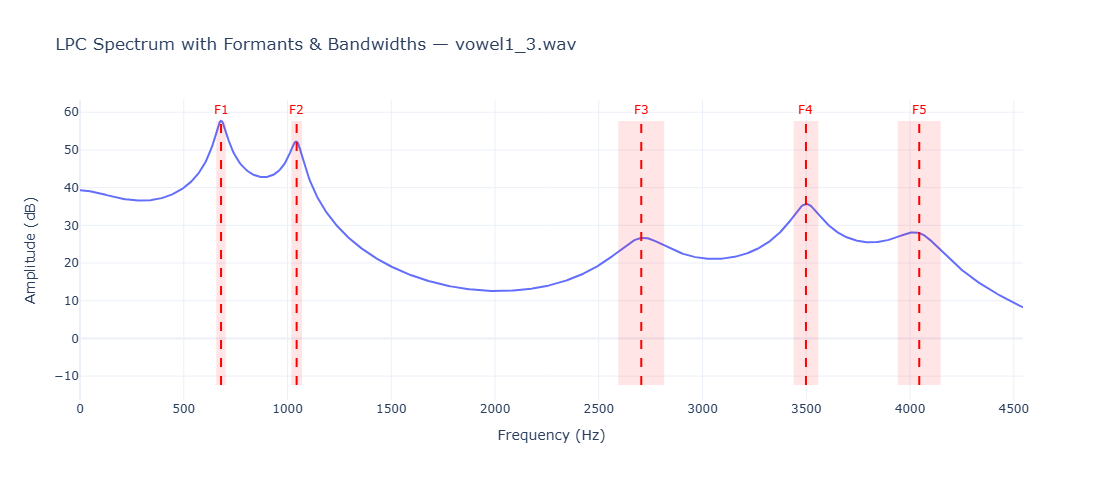

In [29]:
# === LPC spectrum with formant + bandwidth overlays (Plotly, up to F5) ===
import numpy as np
import pandas as pd
import soundfile as sf
from numpy import hamming
from scipy.linalg import solve_toeplitz
from scipy.signal import freqz
import plotly.graph_objects as go

# ---------- Config ----------
wav_file = "vowel1_3.wav" #----------------------------------------------------------------Change Here
formant_csv = "vowel1_formants_bandwidths_new.csv"
center_time = 0.12379
frame_ms = 60.0
# ----------------------------

def compute_lpc_autocorr(x, order):
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
    R = r[:order + 1]
    r_rhs = r[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
    return np.concatenate(([1.0], -a))

# Load audio & take frame
sig, fs = sf.read(wav_file)
sig = sig / (np.max(np.abs(sig)) + 1e-12)
frame_len = int((frame_ms/1000.0) * fs)
c = int(center_time * fs)
start = max(0, c - frame_len//2)
end = min(len(sig), start + frame_len)
frame = sig[start:end]
if len(frame) < frame_len:
    frame = np.pad(frame, (0, frame_len - len(frame)))
windowed = frame * hamming(len(frame))

# LPC analysis
p = int(fs/1000) + 2
a = compute_lpc_autocorr(windowed, p)

# LPC frequency response
w, H = freqz(b=[1.0], a=a, worN=4096)
freqs_hz = w * fs / (2*np.pi)
lpc_db = 20*np.log10(np.maximum(np.abs(H), 1e-12))

# Load formants/bandwidths
df = pd.read_csv(formant_csv)
row = df.loc[df["filename"] == wav_file]
if row.empty:
    raise ValueError(f"{wav_file} not found in {formant_csv}")
F = row[[f"F{i}" for i in range(1,6)]].values.astype(float).ravel()
B = row[[f"B{i}" for i in range(1,6)]].values.astype(float).ravel()

mask = np.isfinite(F) & np.isfinite(B)
F = F[mask]
B = B[mask]

# Limit spectrum to slightly above F5
f5_max = np.nanmax(F) if len(F) >= 5 else np.nanmax(F)
plot_limit = f5_max + 500  # add small buffer

# Build plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=freqs_hz, y=lpc_db, mode="lines", name="LPC Spectrum (dB)"
))

ymin = float(np.nanmin(lpc_db))
ymax = float(np.nanmax(lpc_db))
shapes, annotations = [], []

for i, (f, b) in enumerate(zip(F, B), start=1):
    if not (90 < f < fs/2) or b <= 0:
        continue
    x0 = max(0, f - b/2)
    x1 = min(plot_limit, f + b/2)

    shapes.append(dict(
        type="rect", xref="x", yref="y",
        x0=x0, x1=x1, y0=ymin, y1=ymax,
        fillcolor="rgba(255,0,0,0.10)", line=dict(width=0)
    ))
    shapes.append(dict(
        type="line", xref="x", yref="y",
        x0=f, x1=f, y0=ymin, y1=ymax,
        line=dict(color="red", width=2, dash="dash")
    ))
    annotations.append(dict(
        x=f, y=ymax, xref="x", yref="y",
        text=f"F{i}", showarrow=False, yshift=12, font=dict(size=12, color="red")
    ))

fig.update_layout(
    title=f"LPC Spectrum with Formants & Bandwidths — {wav_file}",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Amplitude (dB)",
    template="plotly_white",
    width=950, height=480,
    shapes=shapes,
    annotations=annotations,
    xaxis=dict(range=[0, plot_limit])
)

fig.show()


Looking at this LPC spectrum with your formant center lines and bandwidth-shaded regions, a few project-relevant points stand out:

Formant Structure is Clear

F1 and F2 peaks are strong and sharply defined — a sign that the LPC analysis is capturing the vocal tract resonances well in the low–mid frequency range.

F3–F5 are visible but less pronounced, which is common for higher formants due to lower excitation energy and stronger damping.

Bandwidths are Physically Reasonable

The shaded areas are fairly narrow for F1 and F2, widening somewhat for higher formants — consistent with speech acoustics theory (higher formants tend to have broader bandwidths because of increased energy loss in the vocal tract).

Formant–Peak Alignment Check

Each dashed red line passes close to a local maximum of the LPC spectrum. This means the PDLPC estimation is well-aligned with the actual spectral peaks for this token.

That’s important for your project because your SVD–formant matching depends on the formant frequencies being physically meaningful.

Why This Figure is Important for Your Pipeline

This serves as a ground truth visualization: it shows exactly what your model is trying to match with the SVD component FFT peaks.

Once you overlay the two chosen SVD components per formant, you’ll be able to visually confirm that those component peaks fall inside these shaded regions, validating your matching + weighted peak method.

If a component peak consistently lands outside these shaded areas, it’s a signal to adjust your matching criterion (±B/2 vs. bandwidth lower bound).

Potential Diagnostic Use

If you generate this plot for every token, you can spot outliers:

Abnormally wide or narrow bandwidths (formant estimation issue).

Peaks that don’t match the LPC envelope (possible segmentation or noise issue).

Missing formants (estimation failed for some high-order poles).

In short — this figure confirms your PD-LPC formant extraction is working as intended for this sample, provides a baseline “map” for validating your SVD component selection, and will be even more powerful when overlaid with the SVD FFT component spectra to prove the correspondence.

If you’d like, I can directly integrate the two SVD component spectra per formant onto this exact LPC + bandwidth plot so you get the side-by-side visual evidence in one figure. That would be the next logical figure for your thesis.

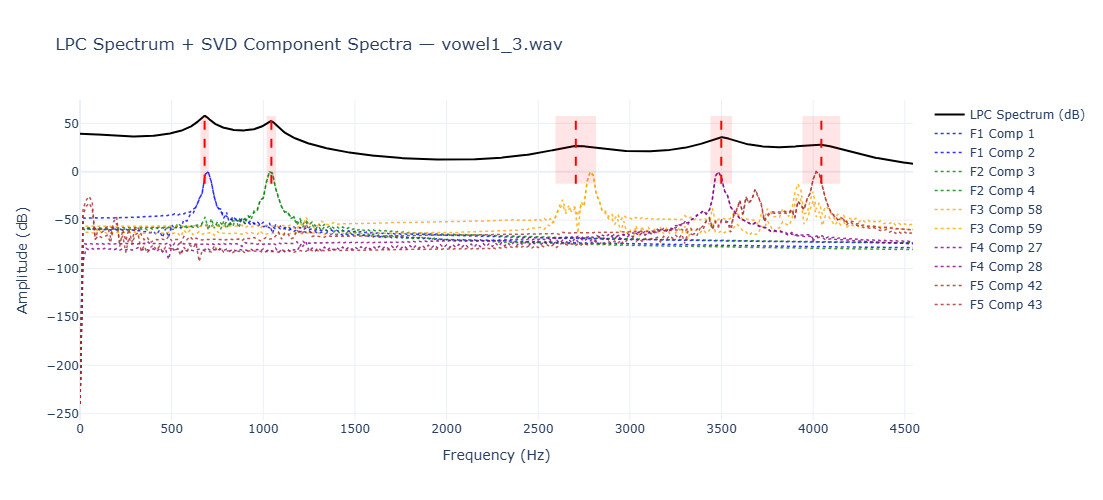

In [34]:
import numpy as np
import pandas as pd
import soundfile as sf
import ast
from numpy import hamming
from scipy.linalg import svd, solve_toeplitz
from scipy.signal import freqz
import plotly.graph_objects as go

# ---------- Config ----------
wav_file = "vowel1_3.wav"
formant_csv = "vowel1_formants_bandwidths_new.csv"
svd_csv = "vowel1_formant_svd_contributions_adaptive.csv"
center_time = 0.12379
frame_ms = 60.0
# ----------------------------

# === Helper functions ===
def compute_lpc_autocorr(x, order):
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
    R = r[:order + 1]
    r_rhs = r[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
    return np.concatenate(([1.0], -a))

def anti_diag_avg(H):
    rows, cols = H.shape
    out = np.zeros(rows + cols - 1)
    cnt = np.zeros_like(out)
    for i in range(rows):
        for j in range(cols):
            out[i + j] += H[i, j]
            cnt[i + j] += 1
    return out / np.maximum(cnt, 1)

def parse_indices(s):
    try:
        return [int(v) for v in ast.literal_eval(str(s))]
    except:
        return []

def component_spectrum(comp_index_1based, U, S, VT, fs):
    i = comp_index_1based - 1
    Hi = S[i] * np.outer(U[:, i], VT[i, :])
    sig_i = anti_diag_avg(Hi)
    sig_i *= hamming(len(sig_i))
    spec = np.abs(np.fft.rfft(sig_i))
    freqs = np.fft.rfftfreq(len(sig_i), d=1/fs)
    spec[0] = 0.0
    peak = np.max(spec) + 1e-12
    spec_db = 20*np.log10(spec / peak + 1e-12)
    return freqs, spec_db

# === Load audio & extract frame ===
sig, fs = sf.read(wav_file)
sig = sig / (np.max(np.abs(sig)) + 1e-12)
frame_len = int((frame_ms/1000.0) * fs)
c = int(center_time * fs)
start = max(0, c - frame_len//2)
end = min(len(sig), start + frame_len)
frame = sig[start:end]
if len(frame) < frame_len:
    frame = np.pad(frame, (0, frame_len - len(frame)))
windowed = frame * hamming(len(frame))

# === LPC analysis ===
p = int(fs/1000) + 2
a = compute_lpc_autocorr(windowed, p)
w, H = freqz(b=[1.0], a=a, worN=4096)
freqs_hz = w * fs / (2*np.pi)
lpc_db = 20*np.log10(np.maximum(np.abs(H), 1e-12))

# === Load formants/bandwidths ===
df_fb = pd.read_csv(formant_csv)
row_fb = df_fb.loc[df_fb["filename"] == wav_file]
if row_fb.empty:
    raise ValueError(f"{wav_file} not found in {formant_csv}")
F = row_fb[[f"F{i}" for i in range(1,6)]].values.astype(float).ravel()
B = row_fb[[f"B{i}" for i in range(1,6)]].values.astype(float).ravel()

# === Load component indexes ===
df_svd = pd.read_csv(svd_csv)
row_svd = df_svd.loc[df_svd["filename"] == wav_file]
if row_svd.empty:
    raise ValueError(f"{wav_file} not found in {svd_csv}")
comp_idx_lists = [parse_indices(row_svd.iloc[0][f"Component_Indexes_F{i}"])[:2] for i in range(1,6)]

# === Build Hankel SVD for components ===
N = len(frame)
L = N // 2
K = N - L + 1
Hankel = np.column_stack([frame[i:i+L] for i in range(K)])
U, S, VT = svd(Hankel, full_matrices=False)

# === Build figure ===
fig = go.Figure()

# LPC spectrum
fig.add_trace(go.Scatter(
    x=freqs_hz, y=lpc_db, mode="lines", name="LPC Spectrum (dB)", line=dict(color="black")
))

ymin = float(np.min(lpc_db))
ymax = float(np.max(lpc_db))

# Shaded bandwidths + formant lines
for i, (f, b) in enumerate(zip(F, B), start=1):
    if not (np.isfinite(f) and np.isfinite(b) and b > 0):
        continue
    x0 = max(0, f - b/2)
    x1 = f + b/2
    fig.add_shape(type="rect", x0=x0, x1=x1, y0=ymin, y1=ymax,
                  fillcolor="rgba(255,0,0,0.10)", line=dict(width=0))
    fig.add_shape(type="line", x0=f, x1=f, y0=ymin, y1=ymax,
                  line=dict(color="red", width=2, dash="dash"))

# Component FFT spectra
colors = ["blue", "green", "orange", "purple", "brown"]  # per formant
for formant_idx, comps in enumerate(comp_idx_lists):
    for comp_num in comps:
        freqs, spec_db = component_spectrum(comp_num, U, S, VT, fs)
        fig.add_trace(go.Scatter(
            x=freqs, y=spec_db,
            mode="lines",
            name=f"F{formant_idx+1} Comp {comp_num}",
            line=dict(width=1.5, dash="dot", color=colors[formant_idx]),
            opacity=0.8
        ))

# Layout
fig.update_layout(
    title=f"LPC Spectrum + SVD Component Spectra — {wav_file}",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Amplitude (dB)",
    template="plotly_white",
    width=950, height=500,
    xaxis=dict(range=[0, np.nanmax(F)+500])
)

fig.show()


This figure gives an even more telling story for your project because it brings both halves of your pipeline together — the PDLPC formants (ground truth spectral markers) and the SVD component FFT spectra (features used for regression).

Here’s what stands out:

1. Direct Evidence of the SVD–Formant Link
For each formant F1–F5, the two SVD components you selected for the weighted peak calculation have dominant spectral peaks inside the shaded bandwidth region from PDLPC.

This visually confirms that your component selection + matching rule is working — the SVD peaks are indeed targeting the same resonant regions the formants represent.

2. Formant-Specific Component Behavior
F1 and F2 components have tall, isolated peaks right at their center frequencies — a strong match to the LPC envelope. This means low-frequency resonances are well captured by only a few SVD components.

Higher formants (F3–F5) show broader and sometimes noisier component spectra, but still with clear peaks in the correct bands. This matches acoustic reality — higher formants are less sharply defined and more prone to overlap.

3. Magnitude Differences Between Components
Some second contributors (e.g., F3 Comp 59) have noticeably lower peak amplitude than the first contributor.
→ This validates your magnitude-weighted averaging method — it gives more influence to the stronger contributor while still considering secondary ones.

4. Cross-Formant Interference
You can see occasional smaller peaks from one formant’s components landing near other formants’ bands (especially in higher frequencies).
→ This is expected because SVD components are not purely formant-isolated — they can carry multiple resonances. But your selection filter keeps only those where the largest peak lies inside the target bandwidth.

5. Pipeline Validation
This figure serves as a core proof-of-concept in your thesis:

The shaded PD-LPC bands are the “target” spectral zones.

The dotted component spectra show that your automatic SVD matching finds the right components without manual tuning.

This visual evidence backs up your numerical RMSE/R² results later in the report.